# Time to slice and dice


Most of the time, the data you work with won’t be perfectly prepared for training models. In this section we’ll explore the various features that 🤗 Datasets provides to clean up your datasets.



## 1. Slicing and dicing our data

For this example we’ll use the Drug Review Dataset that’s hosted on the UC Irvine Machine Learning Repository, which contains patient reviews on various drugs, along with the condition being treated and a 10-star rating of the patient’s satisfaction.

In [1]:
import urllib.request

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
urllib.request.urlretrieve(url, "drugsCom_raw.zip")

('drugsCom_raw.zip', <http.client.HTTPMessage at 0x14eb1da0210>)

In [2]:
import zipfile

with zipfile.ZipFile("drugsCom_raw.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [5]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
drug_dataset = load_dataset("csv", data_files=data_files, delimiter='\t')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

A good practice when doing any sort of data analysis is to grab a small random sample to get a quick feel for the type of data you’re working with. In 🤗 Datasets, we can create a random sample by chaining the `Dataset.shuffle()` and `Dataset.select()` functions together:



In [6]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(100))
drug_sample[:2]

{'Unnamed: 0': [87571, 178045],
 'drugName': ['Naproxen', 'Duloxetine'],
 'condition': ['Gout, Acute', 'ibromyalgia'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."'],
 'rating': [9.0, 3.0],
 'date': ['September 2, 2015', 'November 7, 2011'],
 'usefulCount': [36, 13]}

In [7]:
drug_sample[3]

{'Unnamed: 0': 159268,
 'drugName': 'TriNessa',
 'condition': 'Birth Control',
 'review': '"I am now 21 and have been on TriNessa since I was 15 years old, so 6 years on the same pill is a long time, obviously I love it. I originally was placed on the pill to control my VERY painful pains and cramps during my periods, and to help control acne.  Eventually when I became sexually active when I was 18, the pill was also important as birth control. Never once have I ever had a &quot;pregnancy scare&quot; while on this pill.  I have not noticed any negative effects, no excessive weight gain, or mood swings. The first few months I was on the pill, I had some spotting but after 3 months or so that stopped.  Come time for my period week, my period was a lot less painful and I had lighter bleeding as well. Strongly recommended!"',
 'rating': 10.0,
 'date': 'October 21, 2010',
 'usefulCount': 81}

Note that we’ve fixed the seed in `Dataset.shuffle()` for reproducibility purposes. `Dataset.select()` expects an iterable of indices, so we’ve passed `range(1000)` to grab the first 1,000 examples from the shuffled dataset. From this sample we can already see a few quirks in our dataset:



* The `Unnamed: 0` column looks suspiciously like an anonymized ID for each patient.

* The `condition` column includes a mix of uppercase and lowercase labels.

* The reviews are of varying length and contain a mix of Python line separators (`\r\n`) as well as HTML character codes like `&\#039;`.

Let’s see how we can use 🤗 Datasets to deal with each of these issues. To test the patient ID hypothesis for the `Unnamed: 0` column, we can use the `Dataset.unique()` function to verify that the number of IDs matches the number of rows in each split:



In [8]:
for split in drug_dataset.keys():
    assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))

This seems to confirm our hypothesis, so let’s clean up the dataset a bit by renaming the `Unnamed: 0` column to something a bit more interpretable. We can use the `DatasetDict.rename_column()` function to rename the column across both splits in one go:



In [9]:
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0",
    new_column_name="patient_id"
)
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

Next, let’s normalize all the condition labels using `Dataset.map()`. We can define a simple function that can be applied across all the rows of each split in `drug_dataset`:



In [20]:
def lowercase_condition(example):
    return {"condition": example["condition"].lower()}

In [21]:
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)
drug_dataset = drug_dataset.map(lowercase_condition)

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

In [26]:
drug_dataset["train"]["condition"][:5]

['left ventricular dysfunction',
 'adhd',
 'birth control',
 'birth control',
 'opiate dependence']

It works! Now that we’ve cleaned up the labels, let’s take a look at cleaning up the reviews themselves.

## 2. Creating new columns

Whenever you’re dealing with customer reviews, a good practice is to check the number of words in each review. A review might be just a single word like “Great!” or a full-blown essay with thousands of words, and depending on the use case you’ll need to handle these extremes differently. To compute the number of words in each review, we’ll use a rough heuristic based on splitting each text by whitespace.

Let’s define a simple function that counts the number of words in each review:



In [29]:
def count_reviews_length(example):
    return {"review_length": len(example["review"].split())}

Unlike our `lowercase_condition()` function, `count_reviews_length()` returns a dictionary whose key does not correspond to one of the column names in the dataset. In this case, when `count_reviews_length()` is passed to `Dataset.map()`, it will be applied to all the rows in the dataset to create a new `review_length` column:



In [31]:
drug_dataset = drug_dataset.map(count_reviews_length)
drug_dataset["train"].features.keys()

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

dict_keys(['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'])

In [32]:
drug_dataset["train"][0]


{'patient_id': 206461,
 'drugName': 'Valsartan',
 'condition': 'left ventricular dysfunction',
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'rating': 9.0,
 'date': 'May 20, 2012',
 'usefulCount': 27,
 'review_length': 17}

As expected, we can see a `review_length` column has been added to our training set. We can sort this new column with `Dataset.sort()` to see what the extreme values look like:



In [33]:
drug_dataset["train"].sort("review_length")[:5]

{'patient_id': [111469, 13653, 53602, 135265, 160223],
 'drugName': ['Ledipasvir / sofosbuvir',
  'Amphetamine / dextroamphetamine',
  'Alesse',
  'Zegerid',
  'Rivaroxaban'],
 'condition': ['hepatitis c',
  'adhd',
  'birth control',
  'gerd',
  'deep vein thrombosis'],
 'review': ['"Headache"', '"Great"', '"Awesome"', '"expensive"', '"Good"'],
 'rating': [10.0, 10.0, 10.0, 10.0, 9.0],
 'date': ['February 3, 2015',
  'October 20, 2009',
  'November 23, 2015',
  'March 12, 2008',
  'December 8, 2013'],
 'usefulCount': [41, 3, 0, 32, 11],
 'review_length': [1, 1, 1, 1, 1]}

As we suspected, some reviews contain just a single word, which, although it may be okay for sentiment analysis, would not be informative if we want to predict the condition.



Let’s use the `Dataset.filter()` function to remove reviews that contain fewer than 30 words. Similarly to what we did with the `condition` column, we can filter out the very short reviews by requiring that the reviews have a length above this threshold:



In [34]:
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] >= 30)

Filter:   0%|          | 0/160398 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53471 [00:00<?, ? examples/s]

In [35]:
print(drug_dataset.num_rows)


{'train': 139529, 'test': 46434}


The last thing we need to deal with is the presence of HTML character codes in our reviews. We can use Python’s `html` module to unescape these characters, like so:



In [38]:
import html

text = "I&#039;m a transformer called BERT"
html.unescape(text)

"I'm a transformer called BERT"

We’ll use `Dataset.map()` to unescape all the HTML characters in our corpus:


In [39]:
drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

Map:   0%|          | 0/139529 [00:00<?, ? examples/s]

Map:   0%|          | 0/46434 [00:00<?, ? examples/s]

As you can see, the `Dataset.map()` method is quite useful for processing data — and we haven’t even scratched the surface of everything it can do!



## 3. The `map()` method superpower

The `Dataset.map()` method takes a `batched` argument that, if set to `True`, causes it to send a batch of examples to the map function at once (the batch size is configurable but defaults to 1,000). For instance, the previous map function that unescaped all the HTML took a bit of time to run (you can read the time taken from the progress bars). We can speed this up by processing several elements at the same time using a list comprehension.



When you specify `batched=True` the function receives a dictionary with the fields of the dataset, but each value is now a list of values, and not just a single value. The return value of `Dataset.map()` should be the same: a dictionary with the fields we want to update or add to our dataset, and a list of values. For example, here is another way to unescape all HTML characters, but using `batched=True`:



In [40]:
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(t) for t in x["review"]]},
    batched=True
)

Map:   0%|          | 0/139529 [00:00<?, ? examples/s]

Map:   0%|          | 0/46434 [00:00<?, ? examples/s]

In [41]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["review"], truncation=True)

%time tokenized_dataset = drug_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/139529 [00:00<?, ? examples/s]

Map:   0%|          | 0/46434 [00:00<?, ? examples/s]

CPU times: total: 3min
Wall time: 1min 14s


With `Dataset.map()` and `batched=True` you can change the number of elements in your dataset. This is super useful in many situations where you want to create several training features from one example. 

Let’s have a look at how it works! Here we will tokenize our examples and truncate them to a maximum length of 128, but we will ask the tokenizer to return all the chunks of the texts instead of just the first one. This can be done with `return_overflowing_tokens=True`:


In [42]:
def tokenize_and_split(examples):
    return tokenizer(examples["review"], truncation=True,
                     max_length=128, return_overflowing_tokens=True)

In [51]:
tokenized_dataset["train"]

Dataset({
    features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 139529
})

Let’s test this on one example before using `Dataset.map()` on the whole dataset:



In [54]:
result = tokenize_and_split(drug_dataset["train"][0])
[len(s) for s in result["input_ids"]]

[128, 49]

So, our first example in the training set became two features because it was tokenized to more than the maximum number of tokens we specified: the first one of length 128 and the second one of length 49. Now let’s do this for all elements of the dataset!



The problem is that we’re trying to mix two different datasets of different sizes: the `drug_dataset` columns will have a certain number of examples (the 1,000 in our error), but the `tokenized_dataset` we are building will have more (the 1,463 in the error message; it is more than 1,000 because we are tokenizing long reviews into more than one example by using `return_overflowing_tokens=True`). That doesn’t work for a Dataset, so we need to either remove the columns from the old dataset or make them the same size as they are in the new dataset. We can do the former with the `remove_columns` argument:



In [55]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True,
                                     remove_columns=drug_dataset["train"].column_names)

Map:   0%|          | 0/139529 [00:00<?, ? examples/s]

Map:   0%|          | 0/46434 [00:00<?, ? examples/s]

In [56]:
len(tokenized_dataset["train"]), len(drug_dataset["train"])

(207787, 139529)

We can also deal with the mismatched length problem by making the old columns the same size as the new ones. To do this, we will need the `overflow_to_sample_mapping` field the tokenizer returns when we set `return_overflowing_tokens=True`. It gives us a mapping from a new feature index to the index of the sample it originated from. Using this, we can associate each key present in our original dataset with a list of values of the right size by repeating the values of each example as many times as it generates new features:

In [61]:
def tokenize_and_split(examples):
    result = tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
        padding="max_length"
    )   

    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

We can see it works with `Dataset.map()` without us needing to remove the old columns:



In [62]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
tokenized_dataset

Map:   0%|          | 0/139529 [00:00<?, ? examples/s]

Map:   0%|          | 0/46434 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 207787
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 69202
    })
})

We get the same number of training features as before, but here we’ve kept all the old fields. If you need them for some post-processing after applying your model, you might want to use this approach.



## 4. From Datasets to DataFrames and back

To enable the conversion between various third-party libraries, 🤗 Datasets provides a `Dataset.set_format()` function. This function only changes the output format of the dataset, so you can easily switch to another format without affecting the underlying data format, which is Apache Arrow. 

In [63]:
drug_dataset.set_format("pandas")

Now when we access elements of the dataset we get a `pandas.DataFrame` instead of a dictionary:



In [68]:
drug_dataset["train"][:3]

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
1,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
2,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89


Let’s create a `pandas.DataFrame` for the whole training set by selecting all the elements of drug_dataset["train"]:



In [71]:
train_df = drug_dataset["train"][:]

In [74]:
train_df.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
1,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
2,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89
3,35696,Buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,124
4,155963,Cialis,benign prostatic hyperplasia,"""2nd day on 5mg started to work with rock hard...",2.0,"November 28, 2015",43,68


🚨 Under the hood, `Dataset.set_format()` changes the return format for the dataset’s `__getitem__()` dunder method. This means that when we want to create a new object like `train_df` from a `Dataset` in the `"pandas"` format, we need to slice the whole dataset to obtain a `pandas.DataFrame`. You can verify for yourself that the type of `drug_dataset["train"]` is `Dataset`, irrespective of the output format.



In [78]:
frequencies = (
    train_df["condition"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "condition", "count": "frequency"})
)
frequencies

,condition,frequency
0,birth control,27740
1,depression,8057
2,acne,5225
3,anxiety,5033
4,pain,4788
...,...,...
816,tinea barbae,1
817,acute nonlymphocytic leukemia,1
818,intermittent explosive disorde,1
819,62</span> users found this comment helpful.,1


And once we’re done with our Pandas analysis, we can always create a new `Dataset` object by using the `Dataset.from_pandas()` function as follows:



In [82]:
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

Dataset({
    features: ['condition', 'count'],
    num_rows: 821
})

This wraps up our tour of the various preprocessing techniques available in 🤗 Datasets. To round out the section, let’s create a validation set to prepare the dataset for training a classifier on. Before doing so, we’ll reset the output format of `drug_dataset` from `"pandas"` to `"arrow"`:



In [84]:
drug_dataset.reset_format()
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 139529
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46434
    })
})

## 5. Creating a validation set

🤗 Datasets provides a `Dataset.train_test_split()` function that is based on the famous functionality from `scikit-learn`. Let’s use it to split our training set into `train` and `validation` splits (we set the `seed` argument for reproducibility):



In [85]:
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8, seed=42)
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")
drug_dataset_clean["test"] = drug_dataset["test"]
drug_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 111623
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27906
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46434
    })
})

## 6. Saving a dataset

Although 🤗 Datasets will cache every downloaded dataset and the operations performed on it, there are times when you’ll want to save a dataset to disk (e.g., in case the cache gets deleted). As shown in the table below, 🤗 Datasets provides three main functions to save your dataset in different formats:

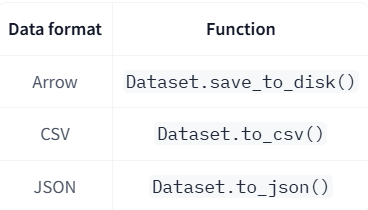

For example, let’s save our cleaned dataset in the Arrow format:



In [86]:
drug_dataset_clean.save_to_disk("drug-reviews")

Saving the dataset (0/1 shards):   0%|          | 0/111623 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/27906 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/46434 [00:00<?, ? examples/s]

where we can see that each split is associated with its own `dataset.arrow` table, and some metadata in `dataset_info.json` and `state.json`. You can think of the Arrow format as a fancy table of columns and rows that is optimized for building high-performance applications that process and transport large datasets.



Once the dataset is saved, we can load it by using the `load_from_disk()` function as follows:



In [87]:
from datasets import load_from_disk

drug_dataset_clean = load_from_disk("drug-reviews")
drug_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 111623
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27906
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46434
    })
})

For the CSV and JSON formats, we have to store each split as a separate file. One way to do this is by iterating over the keys and values in the `DatasetDict` object:



In [89]:
for split, dataset in drug_dataset_clean.items():
    drug_dataset_clean[split].to_csv(f"drug-reviews-{split}.csv")

Creating CSV from Arrow format:   0%|          | 0/112 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/28 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/47 [00:00<?, ?ba/s]

We can then load the csv files as follows:



In [90]:
data_files = {
    "train": "drug-reviews-train.csv",
    "validation": "drug-reviews-validation.csv",
    "test": "drug-reviews-test.csv"
}

drug_dataset_clean = load_dataset("csv", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [91]:
drug_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 111623
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27906
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46434
    })
})